# Slash Class tutorial  
This is notebook demonstrating how the Slash class works


### NOTE: This notebook may need some refactoring
### Firstly, load all the modules

In [1]:
print("start importing modules...")

import time
import sys
sys.path.append('../')
sys.path.append('../SLASH/')
sys.path.append('../EinsumNetworks/src/')
#torch, numpy, ...
import torch
from torchvision.transforms import transforms
import torchvision
torch.cuda.empty_cache()
import numpy as np
import importlib

#own modules
from dataGen import MNIST_Addition, get_data_and_query_list  # dataList, obsList, test_loader, train_loader
from network_nn import Net_nn
import slash
from slash import SLASH
import utils
from einsum_wrapper import EiNet
from mvpp import MVPP

#seeds
utils.set_manual_seed(1)
print("...done")

start importing modules...
...done


### Secondly, load the data and the queries made of those...
This means that we need to generate
- $\mathbf{\mathcal{D}}$ -- the list of the belonging data entries, i.e. $x_{\cdot}$
- $\mathbf{Q}$ -- the list of the queries for the logic program
- $x_l$ -- the raw data to be mapped by $\mathcal{T}(\cdot)$

In [2]:
# Create the datavision.transforms suitable for SPNs
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081, )), transforms.Lambda(lambda x: torch.flatten(x))])
# Generate the training dataset
train_dataset = MNIST_Addition(torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform), 'data/train_data.txt', True)
# Generate the queries and the observation list
dataList, queryList = get_data_and_query_list(train_dataset)
# Load the 'pure' datasets for the mapping
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/', train=False, transform=transform), batch_size=100, shuffle=True)
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/', train=True, transform=transform), batch_size=100, shuffle=True)

### Our training inputs are a set of images and a set of queries as labels

SLASH expects the data in form of lists of a hashmap. Thats because we need to map the input for example two images to its corresponding atoms in the logic program.  
Example MNIST digit addition: [{'im1':[...], 'im2':[...] }, {'im1':[...], 'im2':[...] }, ...]

dataList and queryList length: 30000 30000
observations for first five samples: [':- not addition(i1, i2, 12).' ':- not addition(i1, i2, 15).'
 ':- not addition(i1, i2, 6).' ':- not addition(i1, i2, 5).'
 ':- not addition(i1, i2, 7).']
keys for each input dict_keys(['i1', 'i2'])
/home/arseny/Documents/splpmln/src/slash_mnist_digit_addition


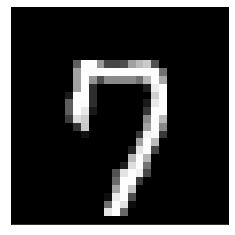

In [3]:
print("dataList and queryList length:", len(dataList), len(queryList))
print("observations for first five samples:",queryList[0:5])
print("keys for each input", dataList[0:5][0].keys())
import os
print(os.getcwd())
import matplotlib.pyplot as plt
#print("the first imput in the list:",dataList[1]['i2'])
first_image = np.array(dataList[1]['i2'], dtype='float')
pixels = first_image.reshape((28, 28))
plt.xticks([])
plt.yticks([])
plt.imshow(pixels, cmap='gray')
plt.savefig('handwritten_digit_seven.svg', dpi=600, bbox_inches='tight')

### The test set contains single images and their labels as class indices. This is for testing of the Probabilistic Circuit

In [4]:
one_test = next(iter(test_loader))
print(one_test[0].shape)
print(one_test[1].shape)

torch.Size([100, 784])
torch.Size([100])


### SLASH Program and Hyperparams

In [6]:
program = '''
img(i1). img(i2).
addition(A,B,N) :- digit(0,+A,-N1), digit(0,+B,-N2), N=N1+N2.
npp(digit(1,X), [0,1,2,3,4,5,6,7,8,9]) :- img(X).
'''

# Define the dictionary of the hyper-parameters
params = {'exp_name': 'MNIST-Addition', 
          'structure': 'poon-domingos','pd_num_pieces':[4,7,28],
          'depth':8, 'num_repetitions':10, 'num_var': 784,
          'pd_width':28, 'pd_height':28, 'use_spn':True,
          'credentials':'AS', 'class_count': 10, 'lr': 0.01,
          'bs':100, 'epochs':10, 'p_num':8, 'drop_out':0.0,
          'learn_prior':True}

## SLASH Instantiation
- Instantiate probabilistic circuits or neural networks.
- Define nnMapping: a dictionary that maps PC/NN names (i.e., strings) to the PC/NN objects (i.e., torch.nn.Module object)
- Define optimizers: a dictionary that maps PC/NN names(i.e., strings) to optimizer (we use the Adam optimizer here).

# Train the network

P(C) is learnable.
P(C) is tensor([-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
        -2.3026, -2.3026], device='cuda:0', requires_grad=True)
train SPN with EM: False
The number of the trainable parameters: 6663440
Epoch 1...


100%|██████████| 300/300 [01:14<00:00,  4.03it/s]


forward time:  6.891417503356934
asp time: 29.700540781021118
backward time:  37.686354637145996
Train Acc: 0.33%, Test Acc: 0.33%
--- train time:  --- 0h:1m:14s
--- test time:  --- 0 days, 0 hours, 0 minutes, 14 seconds, 427 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 1 minutes, 29 seconds, 894 milliseconds
Epoch 2...


100%|██████████| 300/300 [01:15<00:00,  3.99it/s]


forward time:  6.90355372428894
asp time: 30.002299070358276
backward time:  38.03681302070618
Train Acc: 0.81%, Test Acc: 0.82%
--- train time:  --- 0h:1m:15s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 612 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 2 minutes, 59 seconds, 640 milliseconds
Epoch 3...


100%|██████████| 300/300 [01:15<00:00,  3.96it/s]


forward time:  6.876924276351929
asp time: 30.33361291885376
backward time:  38.31692051887512
Train Acc: 0.92%, Test Acc: 0.92%
--- train time:  --- 0h:1m:16s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 597 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 4 minutes, 29 seconds, 954 milliseconds
Epoch 4...


100%|██████████| 300/300 [01:15<00:00,  3.97it/s]


forward time:  6.842116117477417
asp time: 30.190871953964233
backward time:  38.29709076881409
Train Acc: 0.94%, Test Acc: 0.94%
--- train time:  --- 0h:1m:16s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 801 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 5 minutes, 59 seconds, 267 milliseconds
Epoch 5...


100%|██████████| 300/300 [01:15<00:00,  3.96it/s]


forward time:  6.852193355560303
asp time: 30.500367879867554
backward time:  38.22940468788147
Train Acc: 0.95%, Test Acc: 0.94%
--- train time:  --- 0h:1m:16s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 732 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 7 minutes, 30 seconds, 762 milliseconds
Epoch 6...


100%|██████████| 300/300 [01:15<00:00,  3.95it/s]


forward time:  7.012863636016846
asp time: 30.55263328552246
backward time:  38.222431659698486
Train Acc: 0.96%, Test Acc: 0.95%
--- train time:  --- 0h:1m:16s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 835 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 9 minutes, 1 seconds, 564 milliseconds
Epoch 7...


100%|██████████| 300/300 [01:15<00:00,  3.97it/s]


forward time:  6.82903528213501
asp time: 30.3133704662323
backward time:  38.16860342025757
Train Acc: 0.97%, Test Acc: 0.95%
--- train time:  --- 0h:1m:16s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 706 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 10 minutes, 31 seconds, 775 milliseconds
Epoch 8...


100%|██████████| 300/300 [01:15<00:00,  3.97it/s]


forward time:  6.854039192199707
asp time: 30.325448513031006
backward time:  38.18357491493225
Train Acc: 0.97%, Test Acc: 0.95%
--- train time:  --- 0h:1m:16s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 750 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 12 minutes, 1 seconds, 85 milliseconds
Epoch 9...


100%|██████████| 300/300 [01:15<00:00,  3.99it/s]


forward time:  6.772374391555786
asp time: 30.227530002593994
backward time:  38.05618643760681
Train Acc: 0.98%, Test Acc: 0.95%
--- train time:  --- 0h:1m:15s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 855 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 13 minutes, 31 seconds, 189 milliseconds
Epoch 10...


100%|██████████| 300/300 [01:15<00:00,  3.96it/s]


forward time:  6.903679370880127
asp time: 30.542452812194824
backward time:  38.14907264709473
Train Acc: 0.98%, Test Acc: 0.95%
--- train time:  --- 0h:1m:16s
--- test time:  --- 0 days, 0 hours, 0 minutes, 15 seconds, 840 milliseconds
--- total time from beginning:  --- 0 days, 0 hours, 15 minutes, 2 seconds, 811 milliseconds


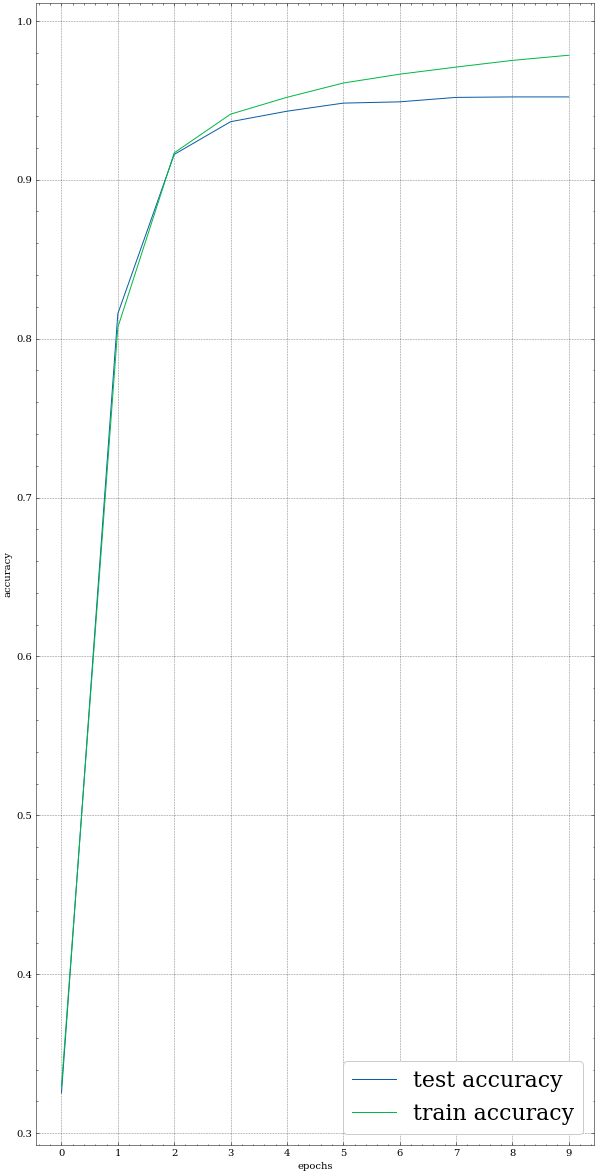

results saved




In [7]:
########
# Start training and testing
########

saveModelPath = 'data/model.pt'

# Iterate over lr and batchsizes


# Setup new SLASH program given the network parameters:
# Firstly, define the network(s).
m = EiNet(structure = params['structure'],
          pd_num_pieces = params['pd_num_pieces'],
          depth = params['depth'],
          num_repetitions = params['num_repetitions'],
          num_var = params['num_var'],
          class_count=params['class_count'],
          pd_width=params['pd_width'],
          pd_height=params['pd_height'],
          use_em=False,
          learn_prior=params['learn_prior']
          )

# Secondly, create a mapping from network to atom and network optimizer.
networkMapping = {'digit': m}
optimizers = {'digit': torch.optim.Adam(m.parameters(), lr=params['lr'], eps=1e-7)}

params['num_trainable_params'] = sum(p.numel() for p in m.parameters() if p.requires_grad)
print('The number of the trainable parameters:', params['num_trainable_params'])

# Thirdly, instantiate SpnAsp using the networks, the mappings and the logic program
SLASHobj = SLASH(program, networkMapping, optimizers)


# Metric lists
train_accuracy_list = []
test_accuracy_list = []
confusion_matrix_list = []
startTime = time.time()


# Train the network and evaluate the performance
for e in range(params['epochs']):
    print('Epoch {}...'.format(e+1))

    time_train= time.time()
    SLASHobj.learn(dataList=dataList, queryList=queryList, epoch=1, batchSize=params['bs'], p_num=params['p_num']) # learn from the data
    # Save the training time for one epoch
    timestamp_train = utils.time_delta_now(time_train, simple_format=True)
    params['train_time'] = timestamp_train

    time_test = time.time()
    test_acc, _, confusion_matrix = SLASHobj.testNetwork('digit', test_loader, ret_confusion=True)
    confusion_matrix_list.append(confusion_matrix)
    train_acc, _ = SLASHobj.testNetwork('digit', train_loader)
    if type(train_accuracy_list) == np.ndarray:
        train_accuracy_list = train_accuracy_list.tolist() 
    train_accuracy_list.append([train_acc, e])
    if type(test_accuracy_list) == np.ndarray:
        test_accuracy_list = test_accuracy_list.tolist()
    test_accuracy_list.append([test_acc, e])
    timestamp_test = utils.time_delta_now(time_test)

    # Save and print statistics
    print('Train Acc: {:0.2f}%, Test Acc: {:0.2f}%'.format(train_acc, test_acc))
    print('--- train time:  ---', timestamp_train)
    print('--- test time:  ---' , timestamp_test)
    print('--- total time from beginning:  ---', utils.time_delta_now(startTime))

# Export results
train_accuracy_list = np.array(train_accuracy_list)
test_accuracy_list = np.array(test_accuracy_list)

suffix = "_epoch:{}_bs:{}_lr:{}".format(params['epochs'], params['bs'], params['lr'])
export_path = "../../results/plots" + suffix +".svg"


utils.export_results(test_accuracy_list=test_accuracy_list, train_accuracy_list=train_accuracy_list,
                     export_path = export_path, export_suffix = suffix, confusion_matrix=confusion_matrix_list[-1],
                     exp_dict=params
                     )
print("results saved\n\n")            

## One example
### 1. Query $Q$ under consideration is ':- not addition(i1, i2, 15).'
### 2. Output probabilities for both images: $P(C_{j}|X=i_{1})$ and $P(C_{j}|X=i_{2})$
### 3. Stable models which fulfils $I\models Q$
### 4. Gradients $\cfrac{\partial \log(P_{\Pi(\theta)}(Q))}{\partial p}$
### 5. Probability of the query $P_{\Pi}(Q)$ 

In [8]:
print(f"The query of for the sum of 15 '{queryList[29918]}'\n")
print(f"Output probabilities, P(C_j|i1), for the first image are \n {np.around(SLASHobj.networkOutputs['digit']['i1'][14].tolist(), decimals=2)}")
print(f"Output probabilities, P(C_j|i2), for the first image are \n {np.around(SLASHobj.networkOutputs['digit']['i2'][14].tolist(), decimals=2)}")
print("The belonging stable models:")
for i in range(SLASHobj.stableModels[14].__len__()):
    print(f"I_{i+1} is {SLASHobj.stableModels[14][i]}\n")
print(f"The gradients with respect to the output probabilities")
print(f"{np.around(list(SLASHobj.networkGradients[14][0]), decimals=2)}")
print(f"{np.around(list(SLASHobj.networkGradients[14][1]), decimals=2)}\n ")
print(f"The probability for the query is {SLASHobj.prob_q[14]}")

The query of for the sum of 15 ':- not addition(i1, i2, 15).'

Output probabilities, P(C_j|i1), for the first image are 
 [0.   0.   0.   0.   0.   0.04 0.   0.02 0.01 0.94]
Output probabilities, P(C_j|i2), for the first image are 
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
The belonging stable models:
I_1 is ['digit(0,i1,6)', 'digit(0,i2,9)', 'addition(i1,i1,12)', 'addition(i2,i1,15)', 'addition(i1,i2,15)', 'addition(i2,i2,18)', 'img(i1)', 'img(i2)']

I_2 is ['digit(0,i1,8)', 'digit(0,i2,7)', 'addition(i2,i1,15)', 'addition(i1,i1,16)', 'addition(i2,i2,14)', 'addition(i1,i2,15)', 'img(i1)', 'img(i2)']

I_3 is ['digit(0,i1,9)', 'digit(0,i2,6)', 'addition(i2,i1,15)', 'addition(i1,i1,18)', 'addition(i2,i2,12)', 'addition(i1,i2,15)', 'img(i1)', 'img(i2)']

I_4 is ['digit(0,i1,7)', 'digit(0,i2,8)', 'addition(i1,i1,14)', 'addition(i2,i1,15)', 'addition(i1,i2,15)', 'addition(i2,i2,16)', 'img(i1)', 'img(i2)']

The gradients with respect to the output probabilities
[-1.07 -1.07 -1.07 -1.07 -1.07 -1.07 -1